In [6]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
sys.path.append('/Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/dataset.py')
import dataset
import cv2
from tensorflow.keras import layers, models, Input

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

In [7]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['AiArt', 'RealArt']
num_classes = len(classes)

# batch size
batch_size = 32

# validation split
validation_size = .16

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

paths = '/Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/DATA'
checkpoint_dir = "models/"

In [8]:
data = dataset.Train_Data_Loader(paths, img_size, classes)
test_images, test_ids = dataset.Test_Data_Loader(paths, img_size, classes)

Reading images from /Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/DATA
Loading AiArt files (Index: 0)
Found 499 files in /Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/DATA/AiArt
Loading RealArt files (Index: 1)
Found 412 files in /Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/DATA/RealArt


libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


Reading images from /Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/DATA
Loading AiArt files (Index: 0)
Found 499 files in /Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/DATA/AiArt
Loading RealArt files (Index: 1)
Found 412 files in /Users/mayahkg/Documents/GitHub/AI-Generated-Images-Classification-Model/DATA/RealArt


libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


In [9]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Size of:
- Training-set:		582
- Test-set:		183
- Validation-set:	146


In [10]:

def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    if cls_pred is not None:
        images, cls_true, cls_pred  = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    else:
        images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    plt.show()

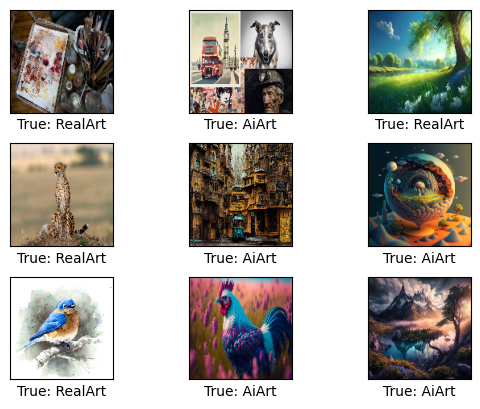

In [11]:
# Get some random images and their labels from the train set.
images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [12]:
# Helper Functions for Tensorflow

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.
    
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new biases, one for each filter.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    layer = tf.nn.relu(layer)

    return layer, weights

# Flattening 
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].

    layer_flat = tf.reshape(layer, [-1, num_features])

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

# New fully connected layer
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [13]:
# Place Holder Variable
x = Input(shape=(img_size_flat,), name='x', dtype=tf.float32)  # Shape: [batch_size, 49152]
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels], name='x_image')  # Shape: [batch_size, 128, 128, 3]
y_true = Input(shape=(num_classes,), name='y_true', dtype=tf.float32)  # Shape: [batch_size, 2]
y_true_cls = tf.argmax(y_true, axis=1, name='y_true_cls')  # Shape: [batch_size]

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
# Convolutional Layers

#layer 1
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv1

#layer 2
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_conv2

#layer 3
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)
layer_conv3